# OSIC

So this is sort of another example of the cli workflow. This notebook was created while I was analyzing data from Kaggle's OSIC contest https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression. This mostly just analyzes the csv file provided, and the 30k dicom images. Also, note that this notebook is "quieter", as most things are unmodified. I will sometimes chime in here and there, but not much.

For quick reference: [DICOM standard browser](https://dicom.innolitics.com/ciods)

In [1]:
from k1lib.imports import *
from k1lib.bioinfo.cli import *
import pydicom

Just to "warm up" multiprocessing stuff. Not strictly necessary tho:

In [2]:
["abc", "de"] | applyMp(lambda x: len(x)) | deref()

[3, 2]

In [3]:
#base = "/home/kelvin/hdd/data/osic-pulmonary-fibrosis-progression"
base = "/home/kelvin/repos/labs/data/osic-pulmonary-fibrosis-progression"

Directory looks something like this:

In [4]:
ls(base)

['/home/kelvin/repos/labs/data/osic-pulmonary-fibrosis-progression/train',
 '/home/kelvin/repos/labs/data/osic-pulmonary-fibrosis-progression/test',
 '/home/kelvin/repos/labs/data/osic-pulmonary-fibrosis-progression/train.csv',
 '/home/kelvin/repos/labs/data/osic-pulmonary-fibrosis-progression/test.csv',
 '/home/kelvin/repos/labs/data/osic-pulmonary-fibrosis-progression/sample_submission.csv']

In [5]:
None | cmd(f"tree {base}") | headOut()

/home/kelvin/repos/labs/data/osic-pulmonary-fibrosis-progression
├── sample_submission.csv
├── test
│   ├── ID00419637202311204720264
│   │   ├── 10.dcm
│   │   ├── 11.dcm
│   │   ├── 12.dcm
│   │   ├── 13.dcm
│   │   ├── 14.dcm
│   │   ├── 15.dcm


## Train.csv

In [6]:
tc = k1lib.Wrapper(cat(f"{base}/train.csv") | table(",") | deref())
tc() | display(3); tc() | shape()

Patient                     Weeks   FVC    Percent            Age   Sex    SmokingStatus   
ID00007637202177411956430   -4      2315   58.2536487166583   79    Male   Ex-smoker       
ID00007637202177411956430   5       2214   55.7121288374434   79    Male   Ex-smoker       


(1550, 7)

Looks nice. 1000 data points seems a bit low though.

### Patient #scans distribution

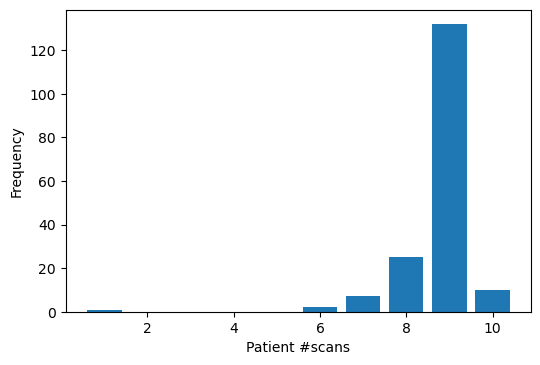

In [7]:
x, y = tc() | cut(0) | count() | ~sort() | cut(0) | count() | sort(1) | permute(1, 0) | transpose() | deref()
plt.bar(x, y); plt.xlabel("Patient #scans"); plt.ylabel("Frequency");

Kay yeah, there may be too little data here. Seems like there are 200 unique patients, and the most frequent #scans each patient has is 9. 9 seems pretty comprehensive for a patient though, but 200 patients? That seems a bit too low.

In [8]:
tc() | unique(0) | shape(0)

177

More precisely, there're 176 patients

### Weeks distribution

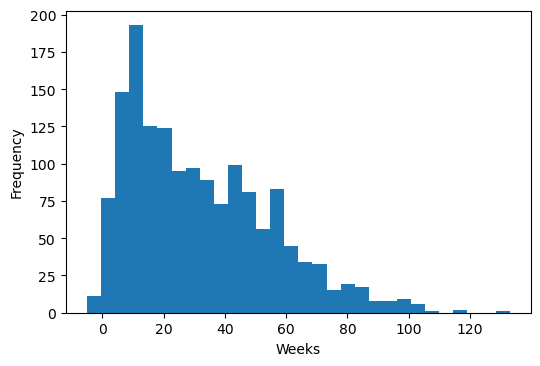

In [9]:
plt.hist(tc() | cut(1) | ~head(1) | toFloat() | toList(), bins=30); plt.xlabel("Weeks"); plt.ylabel("Frequency");

Why are there negative weeks?

In [10]:
tc() | toFloat(1) | inRange(max=0, column=1) | (display(None) & (shape(0) | stdout())) | ignore()

ID00007637202177411956430   -4.0   2315   58.2536487166583   79   Male     Ex-smoker      
ID00023637202179104603099   -3.0   1536   65.3061224489796   71   Female   Ex-smoker      
ID00051637202185848464638   -1.0   1697   81.6454173682945   73   Female   Ex-smoker      
ID00076637202199015035026   -4.0   2298   52.7499770452667   51   Male     Never smoked   
ID00086637202203494931510   -5.0   3367   117.628563443264   65   Female   Never smoked   
ID00093637202205278167493   -1.0   3695   84.9581532235813   69   Male     Ex-smoker      
ID00122637202216437668965   -4.0   2581   69.5012925463162   58   Male     Ex-smoker      
ID00133637202223847701934   -2.0   3195   92.8563124854685   83   Male     Never smoked   
ID00222637202259066229764   -1.0   2644   62.8326996197719   70   Male     Ex-smoker      
ID00233637202260580149633   -3.0   3829   100.784375658033   68   Male     Ex-smoker      
ID00340637202287399835821   -1.0   2345   59.0382678751259   68   Male     Ex-smoker      

Right, so 11 examples of negative weeks. Let's just filter out all of them, it's not worth it to put into our analysis.

### Metric

In [11]:
sqrt2 = math.sqrt(2)
def metric(delta, sig):
    sig = np.clip(sig, 70, inf)
    delta = np.clip(np.abs(delta), -inf, 1000)
    return -sqrt2 * delta / sig - np.log(sqrt2 * sig)

Different lines for different delta values:

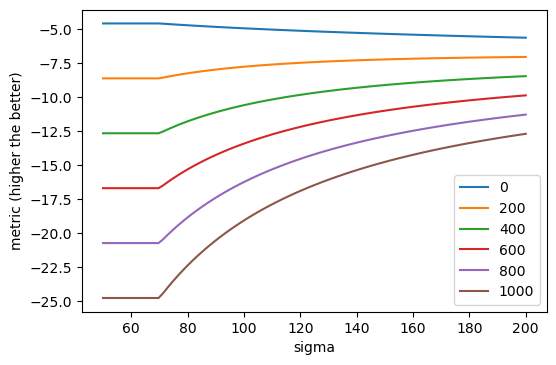

In [12]:
x = torch.linspace(50, 200, 100)
for delta in list(range(0, 1200, 200)): plt.plot(x, metric(delta, x), label=f"{delta}");
plt.legend(); plt.xlabel("sigma"); plt.ylabel("metric (higher the better)");

So, delta small, sigma big will be best. Doesn't apply at the smallest deltas, but who really cares?

### FVC?

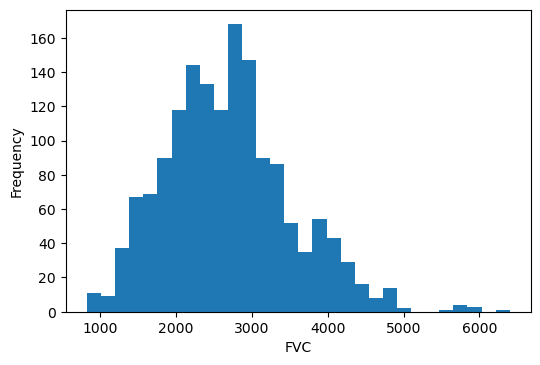

In [13]:
plt.hist(tc() | cut(2) | toFloat() | toList(), bins=30); plt.xlabel("FVC"); plt.ylabel("Frequency");

The typical prediction would be sth like $2500\pm250$, or $\pm10\%$, which sounds very reasonable.

### Percent

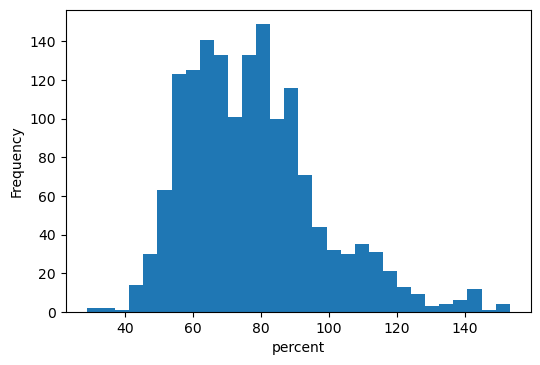

In [14]:
plt.hist(tc() | cut(3) | toFloat() | toList(), bins=30); plt.xlabel("percent"); plt.ylabel("Frequency");

Keep in mind that lots of percent values are greater than 100, so this doesn't actually mean percent. How many?

In [15]:
tc() | toFloat(3) | inRange(100, inf, 3) | (display(3) & (shape(0) | stdout())) | ignore()
195 / (tc() | shape(0)) * 100

ID00012637202177665765362   35   3759   103.076669957223   65   Male     Never smoked   
ID00020637202178344345685   18   2297   117.770713699754   66   Female   Never smoked   
ID00020637202178344345685   19   2145   109.977440525021   66   Female   Never smoked   
195


12.580645161290322

195, or 12% of all datapoints. Yeah, so this can't really be ignored.

### Age

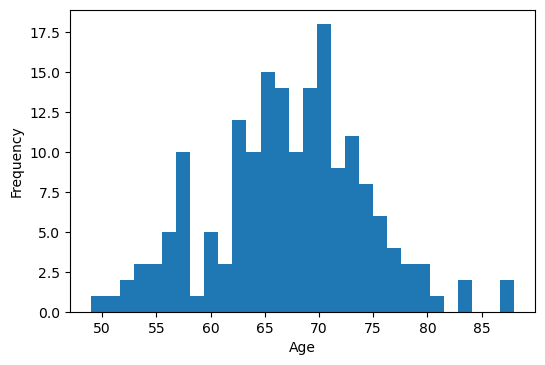

In [16]:
plt.hist(tc() | unique(0) | cut(4) | toFloat() | toList(), bins=30); plt.xlabel("Age"); plt.ylabel("Frequency");

Keep in mind that this is for unique patients. Shape's still similar to the bigger picture though.

### Sex

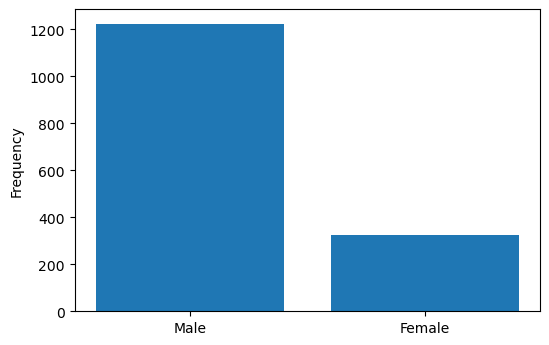

In [17]:
x, y = tc() | cut(5) | ~head(1) | count() | permute(1, 0) | transpose()
plt.bar(x, y); plt.ylabel("Frequency");

This is gonna skew things, but hopefully not a lot.

### Smoking status

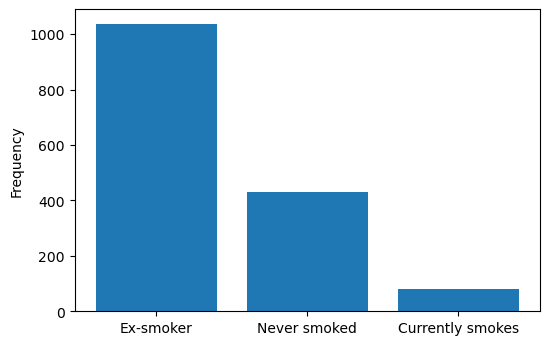

In [18]:
x, y = tc() | cut(6) | ~head(1) | count() | permute(1, 0) | transpose()
plt.bar(x, y); plt.ylabel("Frequency");

## Sample_submission.csv

In [19]:
ss = k1lib.Wrapper(cat(f"{base}/sample_submission.csv") | table(",") | expandE(lambda r: r.split("_"), 0) | deref())

In [20]:
ss() | display(3); ss() | shape()

Patient                     Week   FVC    Confidence   
ID00419637202311204720264   -12    2000   100          
ID00421637202311550012437   -12    2000   100          


(731, 4)

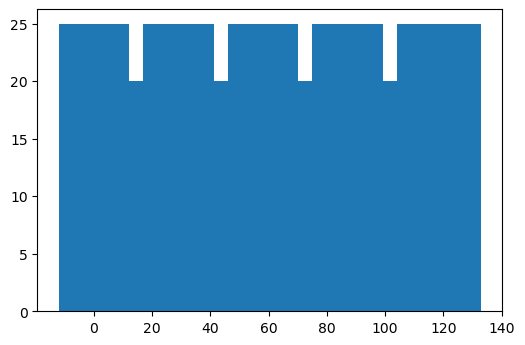

In [21]:
plt.hist(ss() | cut(1) | toFloat() | toList(), bins=30);

So, apparently, the problem requires us to actually predict negative weeks. Yikes. This is gonna be harder than I thought.

In [22]:
ss() | (cut(2) & cut(3)) | (count() | display()).all() | ignore()

1     FVC    0%     
730   2000   100%   
1     Confidence   0%     
730   100          100%   


Sample looks quite reasonable though.

## Train/

In [23]:
dirs = os.listdir(f"{base}/train")
tc() | cut(0) | notIn(dirs) | headOut()
dirs | notIn(tc() | cut(0)) | headOut()

Patient


Quite nice. All the records in the csv file are also inside the "train" folder. How many individual dcm files?

In [24]:
dirs | apply(lambda f: len(os.listdir(f"{base}/train/{f}"))) | toSum()

33026

Damn, that's a lot. File names all indexed nicely?

In [25]:
def analyze(patientDir, returns=False):
    import os
    dcms = os.listdir(f"{base}/train/{patientDir}")
    nums = dcms | sortF(lambda r: float(r.split(".")[0])) | split(".", 0) | toInt() | deref()
    if returns: return nums
    else:
        r = nums | (toMin() & toMax()) | applyS(lambda x: range(next(x), next(x)+1)) | deref()
        if nums != r:
            print(patientDir, r | notIn(nums) | toList())

In [26]:
for patientDir in dirs: analyze(patientDir)

ID00186637202242472088675 [65, 98, 154, 161, 164, 201, 234, 285, 331, 351]
ID00068637202190879923934 [46, 117]
ID00202637202249376026949 [127]
ID00381637202299644114027 [36, 37, 38, 39, 40, 41, 42, 43, 44, 59, 81, 82, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 184, 192, 193, 194, 195, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 270, 271, 281, 282, 283, 284, 285, 286, 287, 288, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 404, 405, 406, 407, 408, 409, 410, 411]
ID00221637202258717315571 [35, 36, 327, 357, 358, 359, 360, 361, 362, 391, 392, 393, 394, 395, 397, 398, 399, 45

Getting fields...

In [27]:
%%time
fields = sorted(list(f"{base}/train" | ls() | applyMp(\
    ls() | apply(lambda dcmF: dir(pydicom.read_file(dcmF))) | breakIf(lambda e: e.startswith("_")).all() | union()\
) | union() | notIn(["PixelData"])))

CPU times: user 73 ms, sys: 57.3 ms, total: 130 ms
Wall time: 3.34 s


In [28]:
%%time
# patient stream, Iterator[dcmO]
_ps = k1lib.Wrapper(f"{base}/train" | ls() | applyMp(\
    ls() | sortF(lambda dcmF: float(dcmF.split("/")[-1].split(".")[0]))\
    | apply(lambda dcmF: pydicom.read_file(dcmF))\
    | apply(lambda dcmO: [getattr(dcmO, field, None) for field in fields]) | toList()\
) | joinStreams() | insertRow(*fields) | deref())

CPU times: user 6.91 s, sys: 174 ms, total: 7.08 s
Wall time: 7.72 s


Notice how we took only several seconds for everything. That's kinda remarkable!

In [29]:
# some filters
def ps(): return _ps() | apply(lambda r: "".join(r), 23) # patient name

In [30]:
ps() | display()

BitsAllocated   BitsStored   BodyPartExamined   Columns   ConvolutionKernel   DeidentificationMethod   DistanceSourceToDetector   DistanceSourceToPatient   FocalSpots   FrameOfReferenceUID                           GantryDetectorTilt   GeneratorPower   HighBit   ImageOrientationPatient                      ImagePositionPatient                               ImageType                                         InstanceNumber   KVP   LargestImagePixelValue   Manufacturer   ManufacturerModelName   Modality   PatientID                   PatientName                 PatientOrientation   PatientPosition   PatientSex   PhotometricInterpretation   PixelPaddingValue   PixelRepresentation   PixelSpacing                     PositionReferenceIndicator   RescaleIntercept   RescaleSlope   RescaleType   RevolutionTime   RotationDirection   Rows   SOPInstanceUID                                 SamplesPerPixel   SeriesInstanceUID                             SingleCollimationWidth   SliceLocation   SliceThic

Quick viz of how this works:

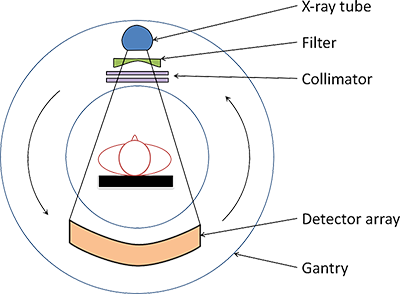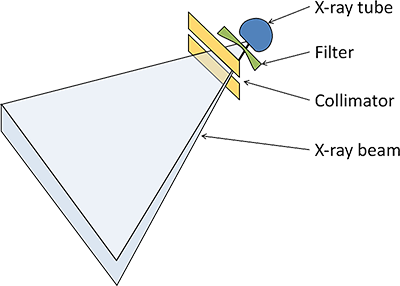

More info: https://www.radiologycafe.com/radiology-trainees/frcr-physics-notes/ct-equipment

Also, "Image Position (Patient) and Image Orientation (Patient) are the 2 only attributes you should ever used when computing distances between slices"

Single value fields:

In [31]:
%%time
singleValues = [i for i, field in enumerate(fields) if (ps() | cut(i) | ~isValue(None) | count() | ~sort() | shape(0) == 2)]
[[fields[fi], ps() | cut(fi) | ~head(1) | item()] for fi in singleValues] | display(None)

BitsAllocated                  16                       
BodyPartExamined               Chest                    
DeidentificationMethod         Table;                   
GantryDetectorTilt             0                        
Modality                       CT                       
PatientSex                                              
PhotometricInterpretation      MONOCHROME2              
RescaleSlope                   1                        
RotationDirection              CW                       
SamplesPerPixel                1                        
SmallestImagePixelValue        0                        
StudyID                                                 
WindowCenterWidthExplanation   ['WINDOW1', 'WINDOW2']   
CPU times: user 8.42 s, sys: 0 ns, total: 8.42 s
Wall time: 8.42 s


What's left?

In [32]:
multiValue = range(len(fields)) | notIn(singleValues) | toList(); len(multiValue)

46

That's a lot to cover. Let's go through them 1 by 1.

In [33]:
def explore(column):
    print(fields[column])
    ps() | ~head(1) | cut(column) | count() | ~sort() | display(None)

In [34]:
multiValue | batched(10, True) | deref()

[[1, 3, 4, 6, 7, 8, 9, 11, 12, 13],
 [14, 15, 16, 17, 18, 19, 20, 22, 23, 24],
 [25, 28, 29, 30, 31, 32, 34, 35, 37, 38],
 [40, 41, 42, 43, 45, 46, 47, 48, 50, 51],
 [52, 53, 54, 55, 57, 58]]

In [35]:
hists = [11, 14, 16, 18, 30, 37, 42, 52, 53, 58] # potential to be histogramable

In [36]:
def plotHist(column, cli=identity()):
    print(column, fields[column])
    plt.hist(ps() | ~head(1) | cut(column) | ~isValue(None) | cli | toFloat() | toList(), bins=30); plt.xlabel(fields[column])

In [37]:
def categorical(column, cli=identity()):
    plt.bar(*(ps() | ~head(1) | cut(column) | cli | count() | apply(lambda e: "None" if e is None else e, 1) | permute(1, 0) | transpose()));
    plt.xlabel(fields[column]); print(fields[column]); plt.xticks(rotation=90)

Number of bits stored for each pixel sample. But why 12, 13 and 16?

1 BitsStored


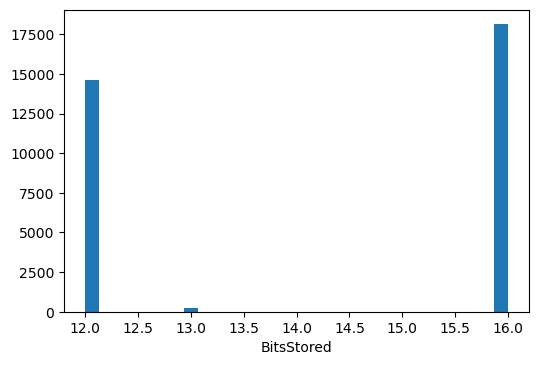

In [38]:
plotHist(1)

Width of image

3 Columns


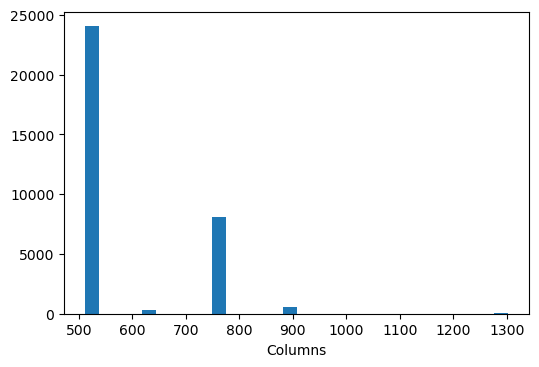

In [39]:
plotHist(3)

Convolution kernel algorithm used to reconstruct the data. I guess this is the algorithm to do the MRI inverse problem I've always wondered about. Apparently, there are multiple algorithms roughly doing the same thing, but may have different tradeoffs. I guess I just didn't expect there to be so many.

ConvolutionKernel


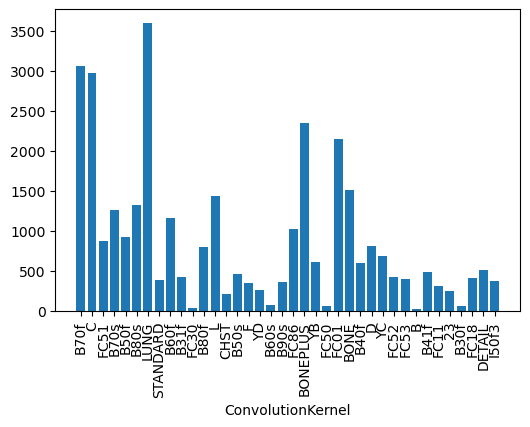

In [40]:
categorical(4, apply(lambda row: "".join(row)))

In mm

6 DistanceSourceToDetector


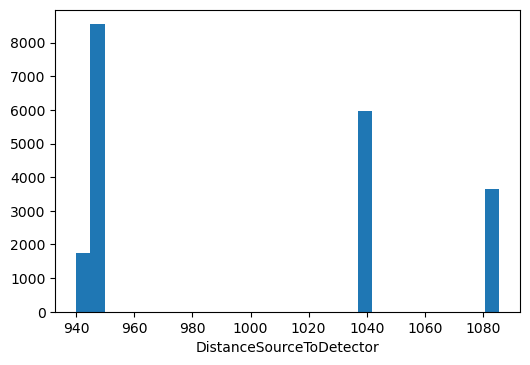

In [41]:
plotHist(6)

In mm, distance from x-ray source to isocenter/patient

7 DistanceSourceToPatient


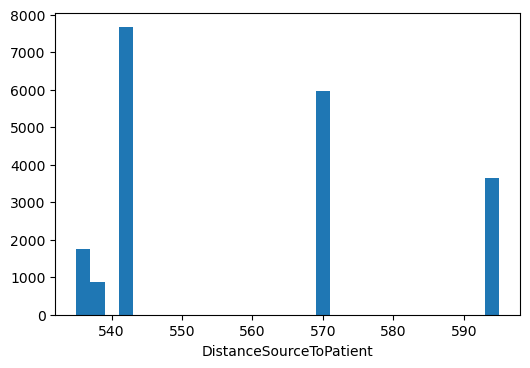

In [42]:
plotHist(7)

Size of focal spot in mm. Ig this is sort of like resolution?

8 FocalSpots


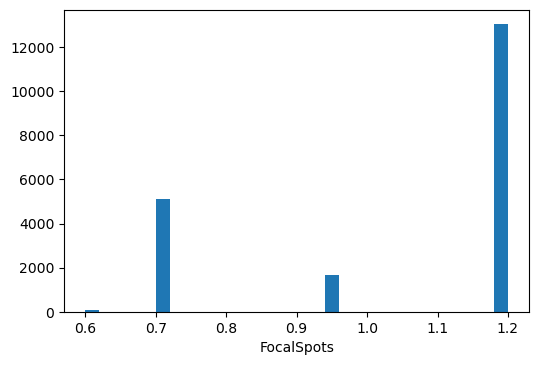

In [43]:
plotHist(8, ~filt(lambda r: type(r) == list))

9 - FrameOfReferenceUID seems to be that random string, assigned for study or sth

In [44]:
ps() | cut(9) | count() | ~sort() | headOut()

[1018, '2.25.103850621004807268762115331499439182923', '3%']
[825, '2.25.26067589961801356770842553401614363097', '2%']
[602, '2.25.10943608917813761096224961520231208680', '2%']
[577, '2.25.145280983379892090408836326254764157961', '2%']
[574, '2.25.71482738880009091674153143085572530828', '2%']
[524, None, '2%']
[521, '2.25.27392021258224904475429237145953835284', '2%']
[512, '2.25.93280772249744696158009885016953113343', '2%']
[498, '2.25.101620500601016521223324645841506278865', '2%']
[497, '2.25.51512508295801930592408267572786009206', '2%']


11 GeneratorPower


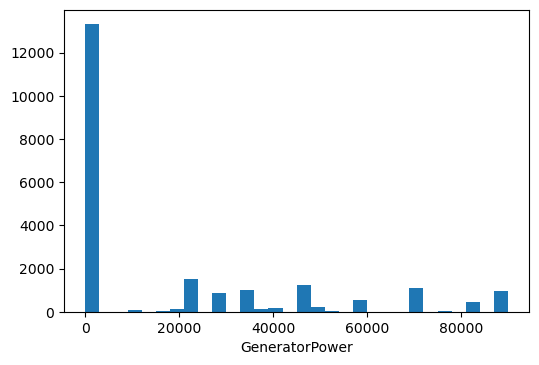

In [45]:
plotHist(11)

Note that that huge spike in the beginning also has a wide distribution to it, but just too small to be noticable.

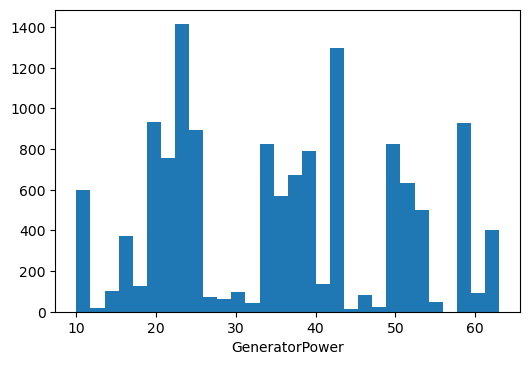

In [46]:
a = np.array(ps() | cut(11) | ~isValue(None) | toFloat() | toList())
plt.hist(a[a<2000], bins=30); plt.xlabel(fields[11]);

Also, this is power in kW provided to the x-ray generator. Some are actually up in the thousands because the operator confused W vs kW lmao. So I gotta filter this out.

Correspond to BitStored - 1. Pretty understandable

12 HighBit


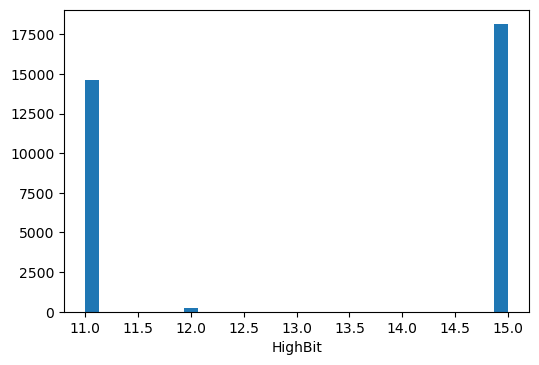

In [47]:
plotHist(12)

Specifies the x, y, and z coordinates of the upper left hand corner of the image. Do I really have to flip voxel images around tediously like this???

ImageOrientationPatient


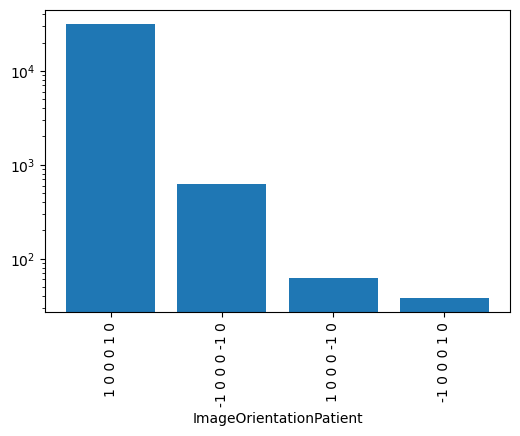

In [48]:
categorical(13, ~isValue(None) | apply(lambda row: " ".join([str(round(e)) for e in row]))); plt.yscale("log");

'ImagePositionPatient'

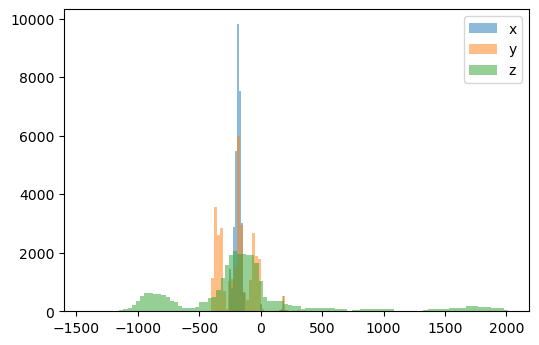

In [49]:
x, y, z = ps() | cut(14) | ~isValue(None) | toFloat(0, 1, 2) | transpose()
plt.hist(x, bins=30, alpha=0.5, label="x");
plt.hist(y, bins=30, alpha=0.5, label="y");
plt.hist(z, bins=100, alpha=0.5, label="z"); plt.legend(); fields[14]

In [50]:
ps() | cut(15) | count() | ~sort() | display(None); fields[15]

12915   ('ORIGINAL', 'PRIMARY', 'AXIAL')                                                                           39%   
9988    ('ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI')                                                            30%   
7133    ('ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX')                                                                  22%   
1245    ('ORIGINAL', 'SECONDARY', 'AXIAL')                                                                         4%    
549     ('ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SEQ')                                                            2%    
394     ('DERIVED', 'SECONDARY', 'AXIAL', 'CT_SOM5 SPI')                                                           1%    
346     ('ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM7 SPI DUAL', 'STD', 'SNRG', 'DET_AB')                              1%    
253     ('ORIGINAL', 'PRIMARY', 'AXIAL', 'VOLUME')                                                                 1%    
64      ('DERIVED', 'PRI

'ImageType'

List of unique values:

In [51]:
ps() | ~head(1) | cut(15) | count() | cut(1) | toSet() | union() | ~isValue("") | deref()

['AVERAGE',
 'SNRG',
 'DERIVED',
 'SECONDARY',
 'CT_SOM5 SPI',
 'VOLUME',
 'DET_AB',
 'CSA RESAMPLED',
 'AXIAL',
 'OTHER',
 'CSA MPR',
 'CSAPARALLEL',
 'PRIMARY',
 'CT_SOM5 SEQ',
 'CT_SOM7 SPI DUAL',
 'HELIX',
 '1',
 'JP2K LOSSY 6:1',
 'STD',
 'REFORMATTED',
 'ORIGINAL']

Feels like #slice? "A number that identifies this image"

16 InstanceNumber


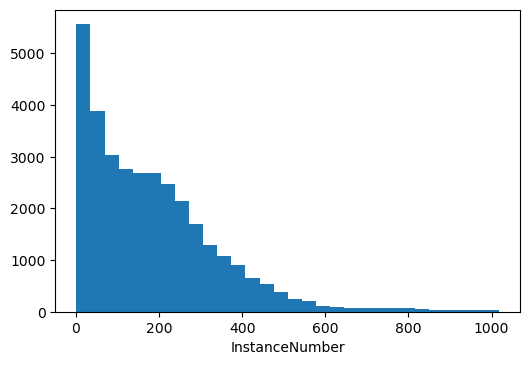

In [52]:
plotHist(16)

kilo volt peek

17 KVP


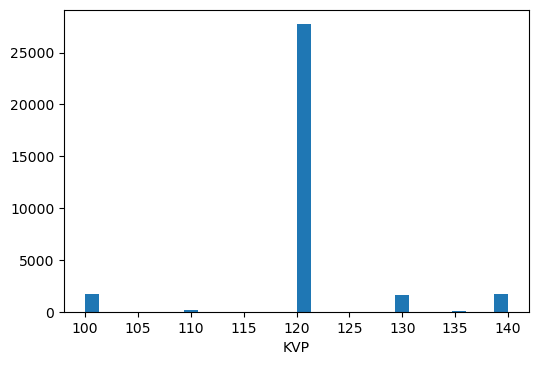

In [53]:
plotHist(17)

Literally, biggest pixel value in the image. Checks out with my own testing

18 LargestImagePixelValue


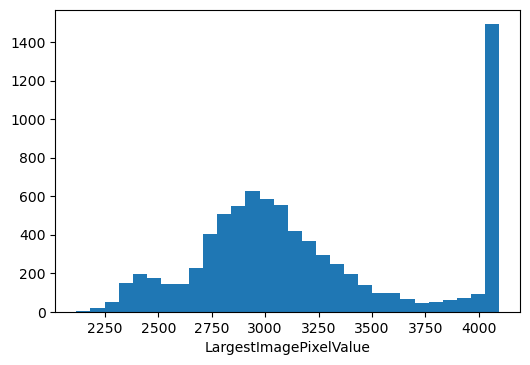

In [54]:
plotHist(18)

Manufacturer


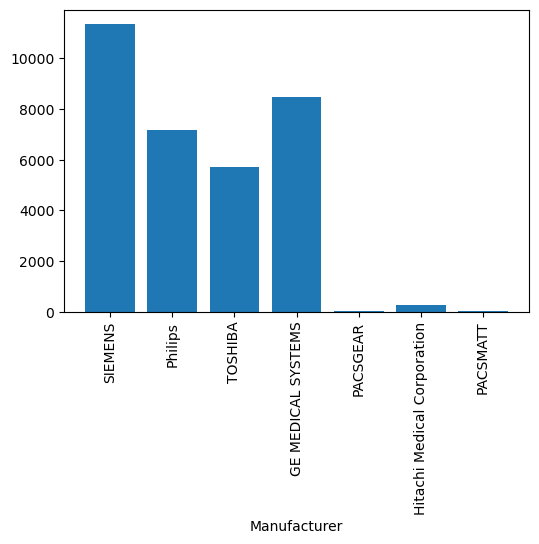

In [55]:
categorical(19)

ManufacturerModelName


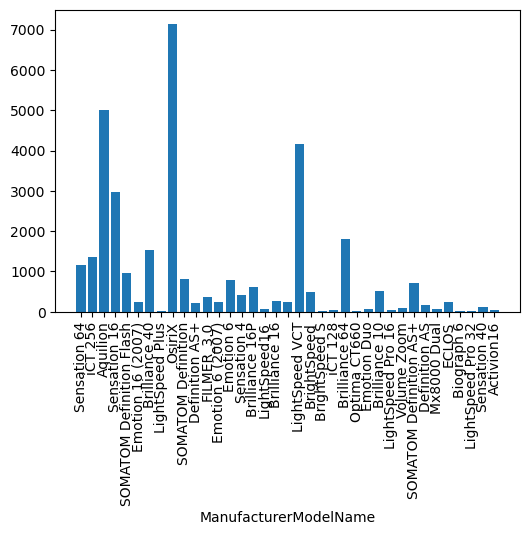

In [56]:
categorical(20)

2 values, patient direction in rows and columns. Values include: A (anterior), P (posterior), RL, H (head), F (foot). So, LP = left posterior, LA = left anterior, RA = right anterior. Empty values just default to LP, cause it has a bunch more stuff in it

PatientOrientation


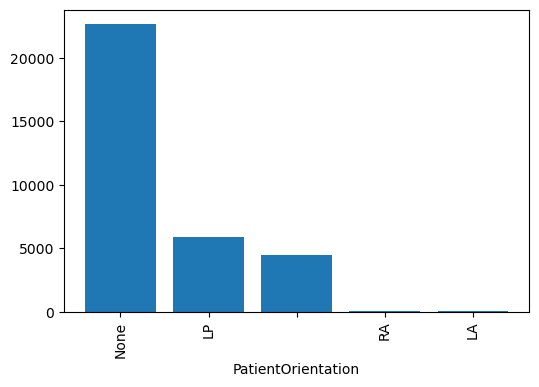

In [57]:
categorical(24, apply(lambda r: "".join(r) if isinstance(r, list) else r))

Quite complex. Refer to docs for more

PatientPosition


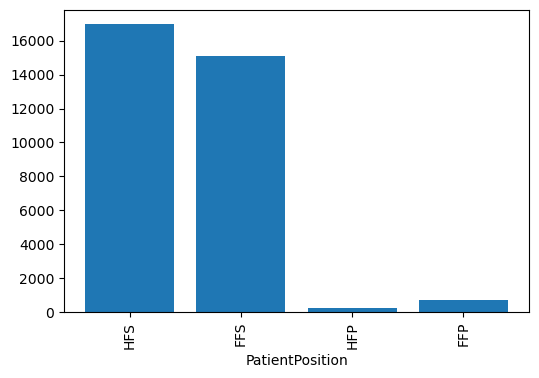

In [58]:
categorical(25)

Pixel value to pad the background

PixelPaddingValue


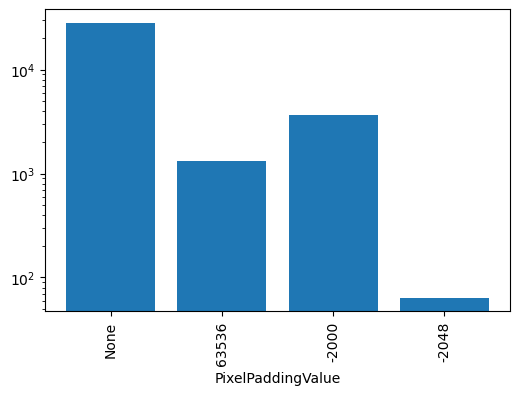

In [59]:
categorical(28, toStr()); plt.yscale("log");

What format are the pixels??? 0 and 1. Let's hope this is automatically handled on getting pixel_array

29 PixelRepresentation


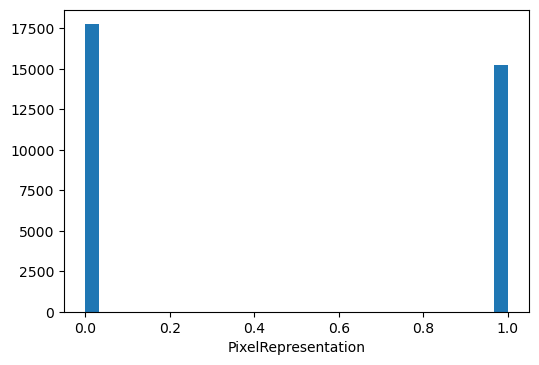

In [60]:
plotHist(29)

x-y spacing between each pixels.

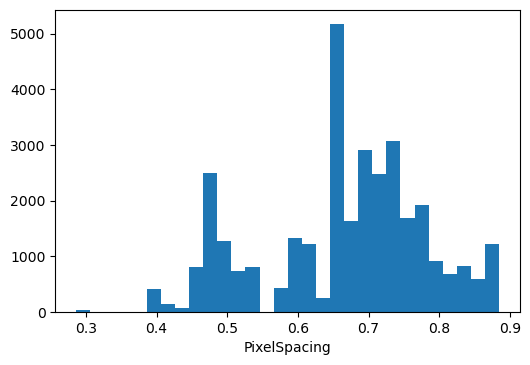

In [61]:
plt.hist(ps() | cut(30) | toFloat(0) | cut(0) | toList(), bins=30); plt.xlabel(fields[30]);

x and y always equal to each other?

In [62]:
all(ps() | cut(30) | toFloat(0, 1) | transpose() | equals())

True

Specifies part of the imaging target that was used as a reference point. Read docs for more

PositionReferenceIndicator


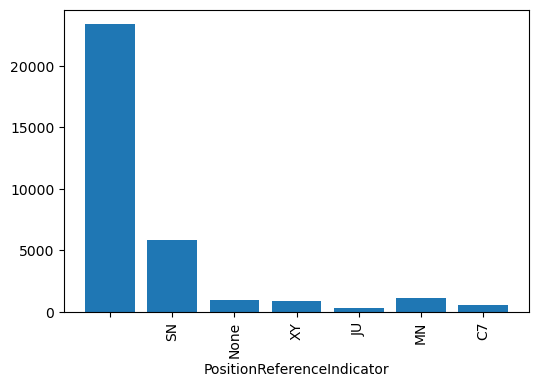

In [63]:
categorical(31)

$output = m\cdot SV+b$, where SV is the stored value. Rescale slope is 1 for all images already btw.

32 RescaleIntercept


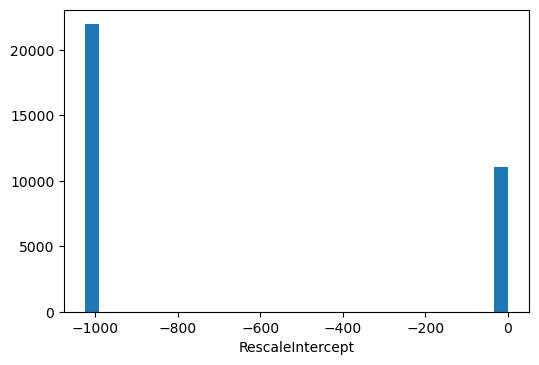

In [64]:
plotHist(32)

Specifies output units of rescale slope and rescale intercept. HU = hounsfield units, US = unspecified. So all of these are just HU then lmao.

RescaleType


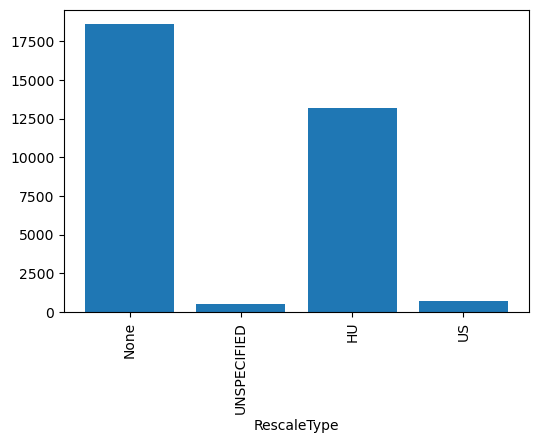

In [65]:
categorical(34)

Time for the x-ray source to rotate around the patient. Kinda hard to believe that these things rotate 1 revolution per fucking 0.4 second??? That's so fast.

35 RevolutionTime


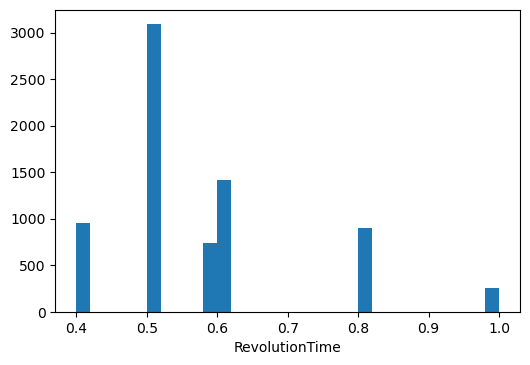

In [66]:
plotHist(35)

Height of image

37 Rows


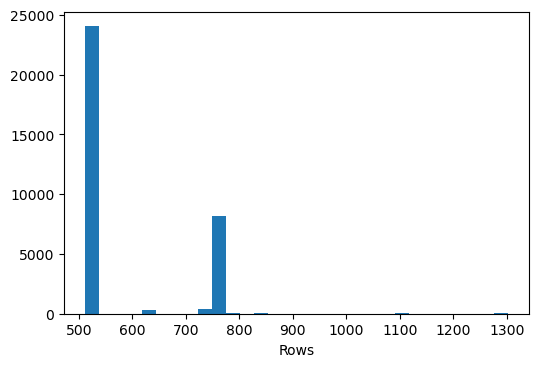

In [67]:
plotHist(37)

This seems like a unique value for every dcm file

In [68]:
ps() | cut(38) | ~isValue(None) | count() | ~sort() | display(4)

1   SOPInstanceUID                                0%   
1   2.25.9463146288515712963633997841404523038    0%   
1   2.25.65126428428746723320146291533300269472   0%   
1   2.25.92410940641125329671602685303131497613   0%   


This one's also full of weird numbers

In [69]:
ps() | cut(40) | ~isValue(None) | count() | ~sort() | display(4)

1018   1.3.6.1.4.1.19291.2.1.2.1162211771921352226130345608929   3%   
825    2.25.67300783861445963103644197317110142934               2%   
602    1.3.6.1.4.1.19291.2.1.2.1162211771921352226130349723959   2%   
577    2.25.168335002352647095587144455728050514290              2%   


??

41 SingleCollimationWidth


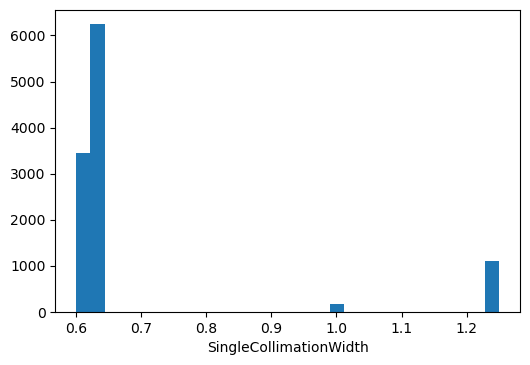

In [70]:
plotHist(41)

I guess this is the locations? Note the tendency to center around 0, cause like, when the lung is exactly at the middle, it sort of should be zero in the comp.

42 SliceLocation


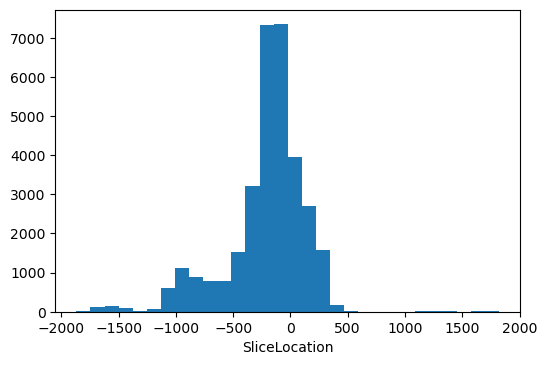

In [71]:
plotHist(42)

Obv. This sort of means that distances below this threadhold are fused into 1 reading.

43 SliceThickness


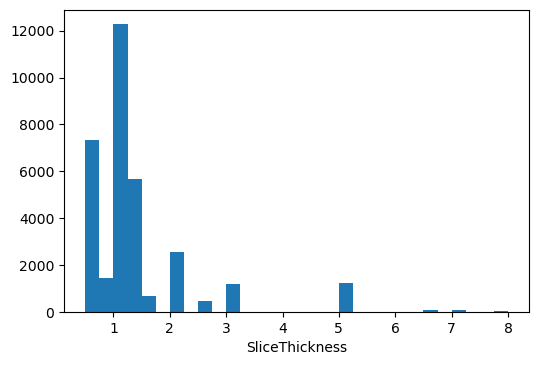

In [72]:
plotHist(43)

Measured in mm. Kinda correspond to pixel spacing. This z axis is much less accurate though, which kinda sucks. Good thing a lot of them clumps toward 0. Also there shouldn't be any negative values here.

45 SpacingBetweenSlices


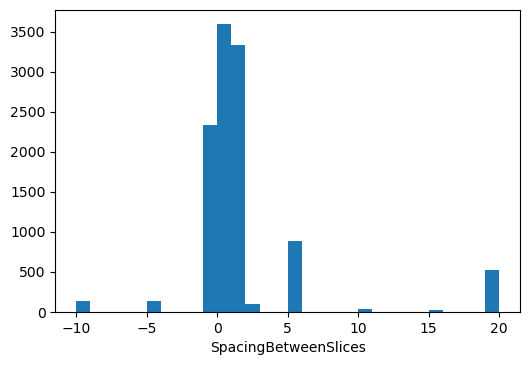

In [73]:
plotHist(45)

The middle bar, expanded out

Text(0.5, 0, 'SpacingBetweenSlices')

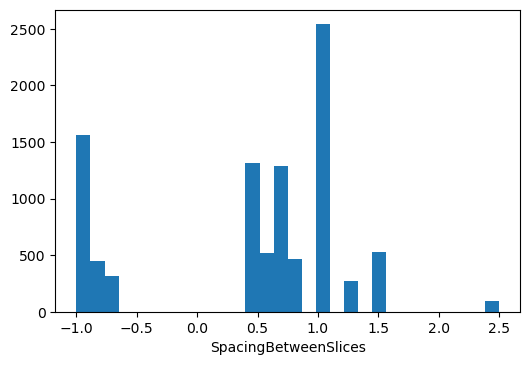

In [74]:
a = np.array(ps() | cut(45) | ~isValue(None) | toFloat() | toList())
plt.hist(a[(a>-3) * (a<3)], bins=30); plt.xlabel(fields[45])

Resolution physics limitation in mm. 0.35 means that any further detail below 0.35mm is considered bogus.

46 SpatialResolution


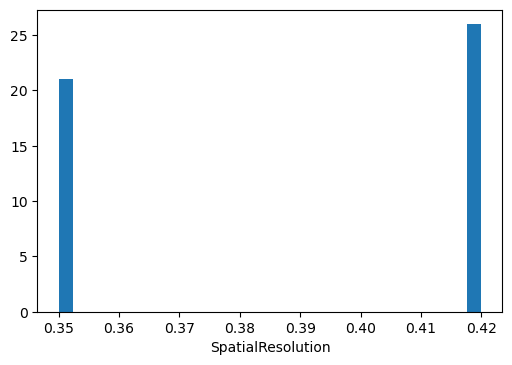

In [75]:
plotHist(46)

Sort of unicode stuff?

SpecificCharacterSet


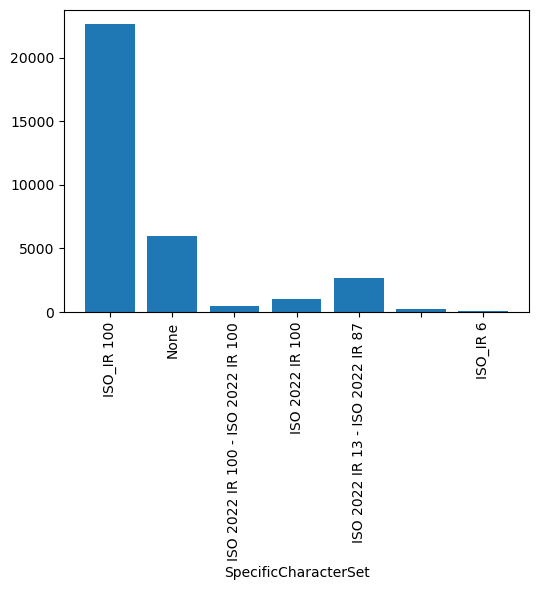

In [76]:
categorical(47, apply(lambda r: " - ".join(r) if isinstance(r, list) else r))

Ah right, after the RevolutionTime thingy, this makes sense. I guess it's how much mm a full rotation will move? Sounds kinda like SpacingBetweenSlices though, so what's up with that? Official definition is `tableFeedPerRotation/totalCollimationWidth`. Should really be as close to 1 as possible to maximize image quality and efficiency.

48 SpiralPitchFactor


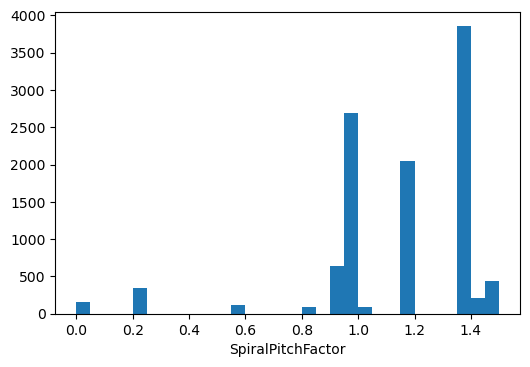

In [77]:
plotHist(48)

Just to visualize, this is how the collimation thingy looks like. I guess these are independent x-ray sources that each gets their own detector? "C" is the total collimation width.

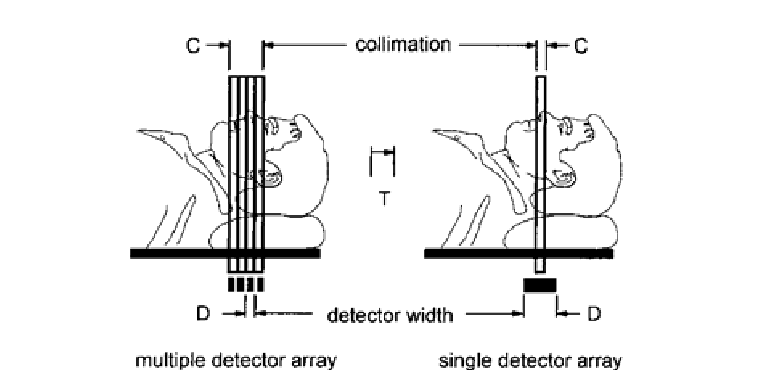

This one's also weird

In [78]:
ps() | cut(50) | ~isValue(None) | count() | ~sort() | headOut()

[1018, '2.25.128099341455079131013013265801613167022', '3%']
[825, '2.25.44730338876702058263099469144293477993', '2%']
[602, '2.25.12038526814304474367356176974755630418', '2%']
[577, '2.25.168009088382578703118904593371568532454', '2%']
[574, '2.25.27570211803454260334890711816742630716', '2%']
[521, '2.25.21250775107781698674952036145409229511', '2%']
[512, '2.25.51524201997550974060815639537176759519', '2%']
[498, '2.25.138385002285841551528805699638475741461', '2%']
[497, '2.25.263916267626722293569390930007441210', '2%']
[493, '2.25.51234585641398128930095037592177078611', '1%']


Interesting question, does it always start with 2.25?

In [79]:
ps() | cut(50) | table(".") | cut(0, 1) | stitch(".") | toFloat() | count() | display()

33026   2.25   100%   


Yep, sure enough

This should sort of equal to total collimation width, because like, if it's much larger than that, then you get sparse spots in the image.

51 TableFeedPerRotation


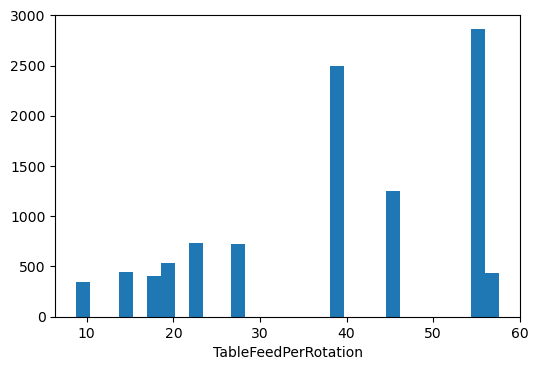

In [80]:
plotHist(51)

Distance from table to center of rotation in mm. Should be 1/2 depth of human body (yep, this checks out). So kinda have to filter out negative values here, cause if so, the patient wouldn't be in the center anymore.

52 TableHeight


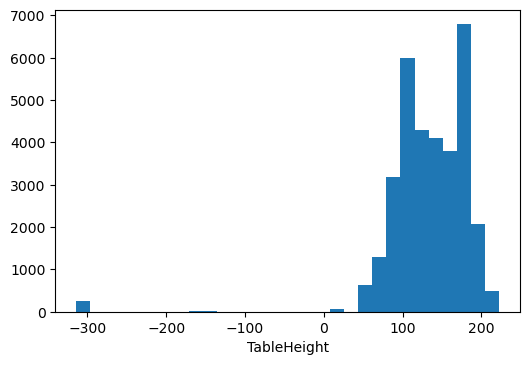

In [81]:
plotHist(52)

Sort of dependent on table feed per rotation, and rotation/s. Apparently, the value is in mm/s, but I mean, typical value of 10cm/s seems outrageously fast, so there has to be something wrong here? UPDATE: so I actually calculated this dependent variable (feed 1cm-6cm/rotation, and 1 rotation/(0.4-1)s), and got back 1-10cm/s for this value. Okay, so I kinda have to reluctantly agree that the table speed is pretty big. However, that doesn't explain the 20cm/s mark.

53 TableSpeed


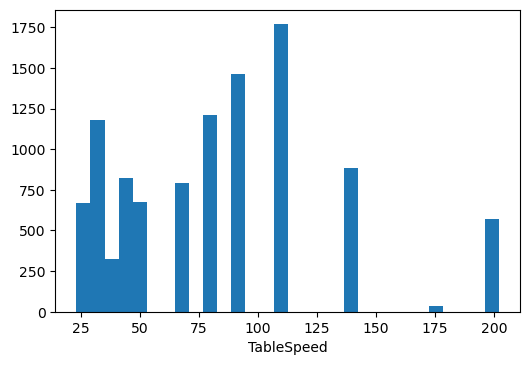

In [82]:
plotHist(53)

54 TotalCollimationWidth


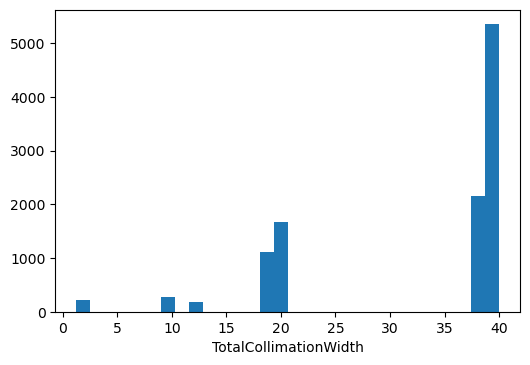

In [83]:
plotHist(54)

Window center and window width is sort of like a filter for values. Anything below center - width/2 becomes min value, anything above center + width/2 becomes max value, and everything in the middle is scaled accordingly like this: $((x - c) / w + 0.5) * (max-min)$. This term $(x-c)/w + 0.5$ goes from 0 to 1, rest is pretty obvious.

WindowCenter


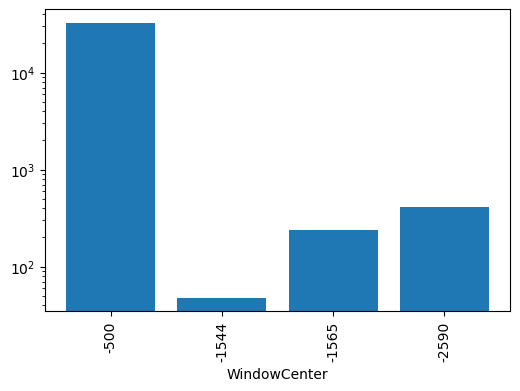

In [84]:
categorical(55, instanceOf([str, float]) | toInt() | toStr()); plt.yscale("log");

57 WindowWidth


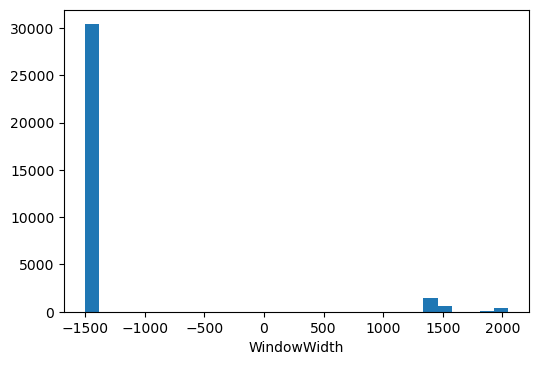

In [85]:
plotHist(57, instanceOf([float, str]));

Tube current in mA

58 XRayTubeCurrent


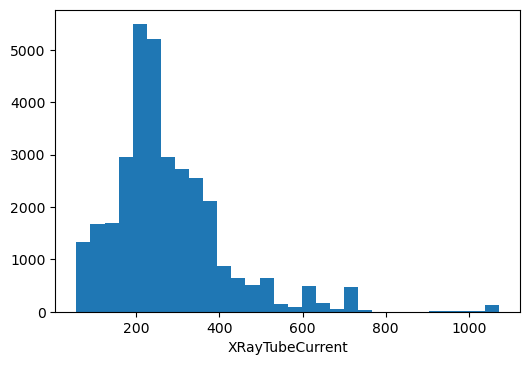

In [86]:
plotHist(58)

In [87]:
fields | insertIdColumn() | display(None)

0    BitsAllocated                  
1    BitsStored                     
2    BodyPartExamined               
3    Columns                        
4    ConvolutionKernel              
5    DeidentificationMethod         
6    DistanceSourceToDetector       
7    DistanceSourceToPatient        
8    FocalSpots                     
9    FrameOfReferenceUID            
10   GantryDetectorTilt             
11   GeneratorPower                 
12   HighBit                        
13   ImageOrientationPatient        
14   ImagePositionPatient           
15   ImageType                      
16   InstanceNumber                 
17   KVP                            
18   LargestImagePixelValue         
19   Manufacturer                   
20   ManufacturerModelName          
21   Modality                       
22   PatientID                      
23   PatientName                    
24   PatientOrientation             
25   PatientPosition                
26   PatientSex                     
2